In [1]:
from neuromaps import plotting as neuroplot
import numpy as np
import os
from glob import glob
from matplotlib import colors as mcolors, pyplot as plt
from neuromaps.images import load_gifti
from neuromaps.datasets import fetch_atlas
import sys
from surfplot import Plot
from neuromaps.datasets import fetch_fslr
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.cm import ScalarMappable
sys.path.insert(0, '..')
from utils.utilities import CONTRASTS, GROUP_CONTRAST_IDS, plot_corr_matrices_across_contrasts, compute_corr_coeff, scale
import pandas as pd

surfaces = fetch_fslr()
lh, rh = surfaces['inflated']

In [2]:
mask = np.load('../data/glasser_medial_wall_mask.npy')
test_subj_ids = np.genfromtxt("../data/MICCAI2020/HCP_test_retest_subj_ids.csv", dtype='<U13')

# from .utils.utilities import CONTRASTS, GROUP_CONTRAST_IDS, plot_corr_matrices_across_contrasts, compute_corr_coeff, scale

colors = [sns.color_palette("Spectral", 7)[0], sns.color_palette("Spectral", 7)[3], sns.color_palette("Spectral", 7)[6]]
alphas = [0.7, 0.7, 0.7]

colors_alphas = []
for c, a in zip(colors, alphas):
    colors_alphas.append((c[0], c[1], c[2], a))

my_cmap = ListedColormap(colors)
norm = BoundaryNorm([0.5,1.5,2.5,3.5], my_cmap.N, clip=False)

In [3]:
def threshold_activation(hemidata, threshold=0.25, abs=True):
    num_verts = int(hemidata.shape[-1] * threshold)
    if abs: hemidata = np.abs(hemidata)
    hemidata_thresh = np.argsort(-hemidata)[:num_verts]
    return hemidata_thresh

def compute_cortex_overlap(prediction, groundtruth, mask=None, threshold=0.10, abs=True, score=False):
    gt_lh = groundtruth[0]
    gt_rh = groundtruth[1]

    if type(mask) is not type(None):
        gt_lh[np.logical_not(mask[0, :])] = 0
        gt_rh[np.logical_not(mask[1, :])] = 0
        masked_gt_lh = gt_lh[mask[0, :]]
        masked_gt_rh = gt_rh[mask[1, :]]

    gt_lh_vertices = threshold_activation(masked_gt_lh, threshold=threshold, abs=abs)
    gt_rh_vertices = threshold_activation(masked_gt_rh, threshold=threshold, abs=abs)

    pred_lh = prediction[0]
    pred_rh = prediction[1]

    if type(mask) is not type(None): # apply the mask before thresholding
        pred_lh[np.logical_not(mask[0, :])] = 0
        pred_rh[np.logical_not(mask[1, :])] = 0
        masked_pred_lh = pred_lh[mask[0, :]]
        masked_pred_rh = pred_rh[mask[1, :]]

    pred_lh_vertices = threshold_activation(masked_pred_lh, threshold=threshold, abs=abs)
    pred_rh_vertices = threshold_activation(masked_pred_rh, threshold=threshold, abs=abs)

    masked_lh = np.zeros_like(gt_lh)
    masked_rh = np.zeros_like(gt_rh)
    masked_lh[gt_lh_vertices] = 0.5
    masked_rh[gt_rh_vertices] = 0.5

    masked_lh[pred_lh_vertices] = 2.5
    masked_rh[pred_rh_vertices] = 2.5

    lh_overlap = np.intersect1d(pred_lh_vertices, gt_lh_vertices)
    rh_overlap = np.intersect1d(pred_rh_vertices, gt_rh_vertices)
    masked_lh[lh_overlap] = 1.5
    masked_rh[rh_overlap] = 1.5

    if type(mask) is not type(None): # apply the mask one more time in case vertices on the medial wall end up in the thresholded sets
        masked_lh[np.logical_not(mask[0, :])] = 0
        masked_rh[np.logical_not(mask[1, :])] = 0

    lh_dice = 2*len(lh_overlap) / (len(pred_lh_vertices) + len(gt_lh_vertices))
    rh_dice = 2*len(rh_overlap) / (len(pred_rh_vertices) + len(gt_rh_vertices))
    dice = (lh_dice + rh_dice) / 2


    if not score: return np.concatenate([masked_lh, masked_rh], axis=-1), dice
    return dice

In [4]:
def dice_auc(prediction, groundtruth, contrast_index, mask=None, dx=0.05, abs=True, return_all=True):
    dices = []
    for th in np.arange(0.05, 0.51, dx):
        score = compute_cortex_overlap(prediction[2*contrast_index: 2*contrast_index+2], groundtruth[2*contrast_index: 2*contrast_index+2], mask=mask, threshold=th, abs=abs, score=True)
        dices.append(score)

    auc = 0.0
    for i in range(len(dices) - 1):
        auc += (dices[i] + dices[i+1]) / 2 * dx
    
    if return_all: return auc, np.array(dices)
    return auc

In [7]:
def plot_dice_scores(threshes, dice_scores, labels, title, marker='x'):
    # dice_scores: [I, T, N]
    # I = # of ICs
    # T = # of threshold values
    # N = # of subjects
    plt.figure(figsize=(8,6))
    for scores, label in zip(dice_scores, labels):
        if type(label) != str:
            label = str(label)
        print(scores.mean(1).shape, len(threshes))
        # plt.errorbar(x=threshes*100, y=scores.mean(1), yerr=scores.std(1), capsize=6.0, label=label)
        plt.plot(threshes*100, scores.mean(1), label=label, marker=marker)

    plt.ylabel('DICE Score')
    plt.xlabel('Threshold (Top X%)')
    plt.xlim([0, 50])
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def subplot_dice_scores(threshes, dice_scores, labels, title, ax, marker='x'):
    # dice_scores: [I, T, N]
    # I = # of ICs
    # T = # of threshold values
    # N = # of subjects
    for scores, label in zip(dice_scores, labels):
        if type(label) != str:
            label = str(label)
            
        # plt.errorbar(x=threshes*100, y=scores.mean(1), yerr=scores.std(1), capsize=6.0, label=label)
        ax.plot(threshes*100, scores.mean(1), label=label, marker=marker)

    ax.set_ylabel('DICE Score')
    ax.set_xlabel('Threshold (Top X%)')
    ax.set_xlim([0, 50])
    ax.set_title(title)
    ax.legend()

## Plotting Params

In [66]:
contrast_index = 7
dx=0.05
threshes = np.arange(0.05, 0.51, dx)
title = f'{CONTRASTS[contrast_index][0]} {CONTRASTS[contrast_index][-1]}'
colors=[ '#f99154', '#358cbb', '#694de2', '#3aac11', '#a89154','#e0d57e']
sns.set_palette(colors)
df = pd.DataFrame(columns=['Source', 'Subject', 'Threshold', 'Dice'])

## BrainSurfCNN

In [67]:
ic = 25
brainsurf_numpy_dir = f"../../aim3_results/HCP_feat64_s8_c{ic}_lr0.01_seed28_epochs50/finetuned_feat64_s8_c{ic}_lr0.01_seed28/predict_on_test_subj/best_corr/"
output_dir = '../../PaperPlots/retest/cortex'

gt_dir = '../../data/test_contrasts/'
gt_end = 'joint_LR_task_contrasts.npy'
pred_dir = brainsurf_numpy_dir
pred_end = 'pred.npy'

# test_subj_ids =['917255']
surf_scores = []
for i in range(len(test_subj_ids)):
    subj = test_subj_ids[i]
    if pred_dir: pred_contrast = np.load(os.path.join(pred_dir, f"{subj}_{pred_end}"))
    if gt_dir: gt_contrast = np.load(os.path.join(gt_dir, f"{subj}_{gt_end}"))

    if len(pred_contrast.shape) > 2:
        pred_contrast = pred_contrast.mean(0) # average across all 8 samples used to predict

    auc, scores = dice_auc( prediction=pred_contrast,
                            groundtruth=gt_contrast,
                            mask=mask,
                            contrast_index=contrast_index,
                            dx=dx)
    for th, score in zip(threshes, scores):
        df.loc[len(df.index)] = ['BrainSurfCNN', subj, th, score]
    surf_scores.append(scores)

surf_scores = np.array(surf_scores).T
print(np.mean(auc).round(3))
print('10%', np.round(surf_scores[1], 3))
print('25%', np.round(surf_scores[4], 3))
print('50%', np.round(surf_scores[-1], 3))
# plot_dice_scores(threshes=threshes,
#                  dice_scores=[surf_scores],
#                  labels=['BrainSurfCNN'],
#                  title=title)
df

0.298
10% [0.623 0.547 0.686 0.637 0.672 0.563 0.644 0.52  0.688 0.607 0.651 0.499
 0.566 0.596 0.471 0.555 0.681 0.648 0.588 0.563 0.633 0.337 0.631 0.599
 0.602 0.582 0.542 0.506 0.661 0.421 0.67  0.625 0.634 0.632 0.271 0.611
 0.558 0.676 0.597]
25% [0.701 0.628 0.791 0.73  0.697 0.633 0.658 0.588 0.707 0.749 0.663 0.648
 0.636 0.644 0.655 0.657 0.761 0.715 0.711 0.623 0.732 0.363 0.695 0.7
 0.715 0.669 0.646 0.661 0.733 0.605 0.688 0.681 0.682 0.658 0.355 0.649
 0.703 0.696 0.666]
50% [0.728 0.692 0.776 0.756 0.713 0.686 0.673 0.631 0.669 0.749 0.68  0.687
 0.679 0.688 0.708 0.676 0.711 0.713 0.726 0.661 0.742 0.506 0.679 0.709
 0.749 0.666 0.676 0.722 0.735 0.687 0.689 0.724 0.712 0.685 0.541 0.666
 0.726 0.701 0.711]


,Source,Subject,Threshold,Dice
0,BrainSurfCNN,103818,0.05,0.533851
1,BrainSurfCNN,103818,0.10,0.623064
2,BrainSurfCNN,103818,0.15,0.668389
3,BrainSurfCNN,103818,0.20,0.691549
4,BrainSurfCNN,103818,0.25,0.700933
...,...,...,...,...
385,BrainSurfCNN,917255,0.30,0.683584
386,BrainSurfCNN,917255,0.35,0.691572
387,BrainSurfCNN,917255,0.40,0.699498
388,BrainSurfCNN,917255,0.45,0.706075


## BrainSERF

In [68]:
ic = 25
brainsurf_numpy_dir = f"../../aim3_results/HCP_feat64_s8_c{ic}_lr0.01_seed28_epochs50/se_attn_finetuned_feat64_s8_c{ic}_lr0.01_seed28/predict_on_test_subj/best_corr/"
output_dir = '../../PaperPlots/retest/cortex'

gt_dir = '../../data/test_contrasts/'
gt_end = 'joint_LR_task_contrasts.npy'
pred_dir = brainsurf_numpy_dir
pred_end = 'pred.npy'


serf_scores = []
for i in range(len(test_subj_ids)):
    subj = test_subj_ids[i]
    if pred_dir: pred_contrast = np.load(os.path.join(pred_dir, f"{subj}_{pred_end}"))
    if gt_dir: gt_contrast = np.load(os.path.join(gt_dir, f"{subj}_{gt_end}"))

    if len(pred_contrast.shape) > 2:
        pred_contrast = pred_contrast.mean(0) # average across all 8 samples used to predict

    auc, scores = dice_auc( prediction=pred_contrast,
                            groundtruth=gt_contrast,
                            mask=mask,
                            contrast_index=contrast_index,
                            dx=dx)
    for th, score in zip(threshes, scores):
        df.loc[len(df.index)] = ['BrainSERF (ours)', subj, th, score]
    # df.loc[len(df.index)] = ('BrainSERF (ours)', subj, 'AUC', auc)
    serf_scores.append(scores)

serf_scores = np.array(serf_scores).T
print(np.mean(auc).round(3))
print('10%', np.round(serf_scores[1], 3))
print('25%', np.round(serf_scores[4], 3))
print('50%', np.round(serf_scores[-1], 3))
# plot_dice_scores(threshes=threshes,
#                  dice_scores=[serf_scores],
#                  labels=['BrainSERF'],
#                  title=title)

0.3
10% [0.635 0.544 0.676 0.647 0.677 0.57  0.658 0.52  0.69  0.614 0.653 0.495
 0.584 0.603 0.497 0.535 0.678 0.662 0.586 0.566 0.632 0.333 0.652 0.611
 0.605 0.605 0.543 0.529 0.658 0.423 0.65  0.625 0.629 0.651 0.272 0.621
 0.559 0.686 0.603]
25% [0.71  0.646 0.788 0.746 0.698 0.641 0.664 0.599 0.714 0.745 0.675 0.652
 0.644 0.649 0.667 0.654 0.77  0.721 0.707 0.622 0.73  0.365 0.711 0.695
 0.721 0.667 0.641 0.67  0.734 0.601 0.684 0.676 0.689 0.668 0.371 0.658
 0.693 0.698 0.67 ]
50% [0.732 0.703 0.782 0.774 0.716 0.688 0.672 0.634 0.67  0.752 0.679 0.689
 0.682 0.692 0.711 0.678 0.714 0.709 0.725 0.662 0.746 0.497 0.687 0.704
 0.748 0.666 0.676 0.727 0.728 0.693 0.69  0.71  0.722 0.695 0.549 0.667
 0.719 0.705 0.721]


## BrainSurfGCN

In [69]:
ic = 50
brainsurf_numpy_dir = f"../../aim3_results/HCP_feat64_s8_c{ic}_lr0.01_seed28_epochs50/gnn_finetuned_feat64_s8_c{ic}_lr0.01_seed28/predict_on_test_subj/best_corr/"
output_dir = '../../PaperPlots/retest/cortex'

gt_dir = '../../data/test_contrasts/'
gt_end = 'joint_LR_task_contrasts.npy'
pred_dir = brainsurf_numpy_dir
pred_end = 'pred.npy'


gcn_scores = []
for i in range(len(test_subj_ids)):
    subj = test_subj_ids[i]
    if pred_dir: pred_contrast = np.load(os.path.join(pred_dir, f"{subj}_{pred_end}"))
    if gt_dir: gt_contrast = np.load(os.path.join(gt_dir, f"{subj}_{gt_end}"))

    if len(pred_contrast.shape) > 2:
        pred_contrast = pred_contrast.mean(0) # average across all 8 samples used to predict

    auc, scores = dice_auc( prediction=pred_contrast,
                            groundtruth=gt_contrast,
                            mask=mask,
                            contrast_index=contrast_index,
                            dx=dx)
    for th, score in zip(threshes, scores):
        df.loc[len(df.index)] = ['BrainSurfGCN (ours)', subj, th, score]

    # df.loc[len(df.index)] = ('BrainSurfGCN (ours)', subj, 'AUC', auc)
    gcn_scores.append(scores)

gcn_scores = np.array(gcn_scores).T
print(np.mean(auc).round(3))
print('10%', np.round(gcn_scores[1], 3))
print('25%', np.round(gcn_scores[4], 3))
print('50%', np.round(gcn_scores[-1], 3))
# plot_dice_scores(threshes=threshes,
#                  dice_scores=[gcn_scores],
#                  labels=['BrainSurfGCN'],
#                  title=title)

0.305
10% [0.593 0.54  0.683 0.664 0.686 0.581 0.632 0.531 0.677 0.598 0.648 0.499
 0.595 0.583 0.528 0.578 0.704 0.672 0.611 0.566 0.656 0.326 0.643 0.638
 0.644 0.609 0.584 0.497 0.669 0.44  0.67  0.608 0.658 0.638 0.274 0.614
 0.559 0.68  0.594]
25% [0.705 0.66  0.791 0.751 0.709 0.648 0.676 0.606 0.719 0.744 0.646 0.665
 0.647 0.653 0.703 0.672 0.782 0.73  0.718 0.62  0.742 0.374 0.72  0.714
 0.725 0.668 0.655 0.685 0.734 0.612 0.71  0.682 0.697 0.67  0.368 0.653
 0.685 0.704 0.693]
50% [0.74  0.713 0.79  0.775 0.742 0.689 0.673 0.639 0.677 0.748 0.673 0.693
 0.688 0.695 0.731 0.688 0.732 0.729 0.721 0.664 0.755 0.508 0.692 0.721
 0.755 0.679 0.676 0.718 0.734 0.701 0.698 0.729 0.727 0.7   0.546 0.673
 0.721 0.706 0.73 ]


## Retest

In [70]:
retest_numpy_dir = '../../data/retest_contrasts/contrasts/'
output_dir = '../../PaperPlots/retest/cortex'

gt_dir = '../../data/test_contrasts/'
gt_end = 'joint_LR_task_contrasts.npy'
pred_dir = retest_numpy_dir
pred_end = 'pred.npy'
pred_end = 'joint_LR_task_contrasts.npy'


retest_scores = []
auc_scores = []
# test_subj_ids =['917255']
for i in range(len(test_subj_ids)):
    subj = test_subj_ids[i]
    if pred_dir: pred_contrast = np.load(os.path.join(pred_dir, f"{subj}_{pred_end}"))
    if gt_dir: gt_contrast = np.load(os.path.join(gt_dir, f"{subj}_{gt_end}"))

    if len(pred_contrast.shape) > 2:
        pred_contrast = pred_contrast.mean(0) # average across all 8 samples used to predict

    auc, scores = dice_auc( prediction=pred_contrast,
                            groundtruth=gt_contrast,
                            mask=mask,
                            contrast_index=contrast_index,
                            dx=dx)
    for th, score in zip(threshes, scores):
        df.loc[len(df.index)] = ('Retest', subj, th, score)
    # df.loc[len(df.index)] = ('Retest', subj, 'AUC', auc)
    retest_scores.append(scores)
    auc_scores.append(auc)


retest_scores = np.array(retest_scores).T
print(retest_scores.shape)
print(np.mean(auc_scores).round(3))
print('10%', np.round(retest_scores[1], 3))
print('25%', np.round(retest_scores[4], 3))
print('50%', np.round(retest_scores[-1], 3))
# plot_dice_scores(threshes=threshes,
#                  dice_scores=[retest_scores],
#                  labels=['Retest'],
#                  title=title)
df

(10, 39)
0.302
10% [0.666 0.6   0.743 0.712 0.726 0.649 0.673 0.565 0.676 0.672 0.771 0.66
 0.709 0.567 0.66  0.59  0.74  0.705 0.546 0.583 0.677 0.487 0.688 0.689
 0.645 0.487 0.656 0.567 0.645 0.516 0.617 0.608 0.713 0.668 0.353 0.693
 0.656 0.724 0.535]
25% [0.744 0.634 0.804 0.739 0.734 0.672 0.651 0.587 0.7   0.741 0.749 0.696
 0.707 0.548 0.717 0.658 0.774 0.765 0.672 0.657 0.767 0.57  0.737 0.71
 0.721 0.562 0.686 0.642 0.732 0.651 0.59  0.674 0.72  0.673 0.393 0.687
 0.731 0.738 0.61 ]
50% [0.754 0.679 0.775 0.735 0.734 0.704 0.652 0.636 0.69  0.717 0.72  0.702
 0.716 0.606 0.711 0.673 0.742 0.732 0.679 0.679 0.774 0.674 0.737 0.707
 0.74  0.634 0.693 0.709 0.732 0.714 0.607 0.713 0.715 0.693 0.546 0.702
 0.768 0.732 0.658]


,Source,Subject,Threshold,Dice
0,BrainSurfCNN,103818,0.05,0.533851
1,BrainSurfCNN,103818,0.10,0.623064
2,BrainSurfCNN,103818,0.15,0.668389
3,BrainSurfCNN,103818,0.20,0.691549
4,BrainSurfCNN,103818,0.25,0.700933
...,...,...,...,...
1555,Retest,917255,0.30,0.619576
1556,Retest,917255,0.35,0.629447
1557,Retest,917255,0.40,0.636386
1558,Retest,917255,0.45,0.645672


## Model Comparison

In [71]:
def sns_plot_dice_scores(data, title):
    # dice_scores: [I, T, N]
    # I = # of ICs
    # T = # of threshold values
    # N = # of subjects
    plt.figure(figsize=(8,6))
    sns.lineplot(x='Threshold', y='Dice',
             hue="Source",
             data=data, 
             errorbar=('se'))
    plt.ylim([0.2,0.75])
    plt.title(title)

def subplot_dice_scores(data, ax, title):
    # dice_scores: [I, T, N]
    # I = # of ICs
    # T = # of threshold values
    # N = # of subjects
    sns.lineplot(x='Threshold', y='Dice',
             hue="Source",
             data=data, 
             ax=ax,
             errorbar=('se'))
    ax.set_title(title)
    ax.set_ylim([0.0, 0.75])

In [72]:
df.columns
df[df['Threshold'] == 'AUC']

,Source,Subject,Threshold,Dice


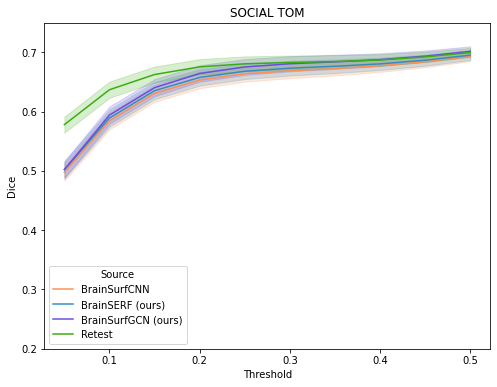

In [73]:
sns_plot_dice_scores(df, title)

## All Tasks

LANGUAGE MATH
LANGUAGE STORY
LANGUAGE MATH-STORY
RELATIONAL MATCH
RELATIONAL REL
RELATIONAL MATCH-REL
SOCIAL RANDOM
SOCIAL TOM
SOCIAL TOM-RANDOM
EMOTION FACES
EMOTION SHAPES
EMOTION FACES-SHAPES
WM 2BK_BODY
WM 2BK_FACE
WM 2BK_PLACE
WM 2BK_TOOL
WM 0BK_BODY
WM 0BK_FACE
WM 0BK_PLACE
WM 0BK_TOOL
WM 2BK
WM 0BK
WM 2BK-0BK
WM BODY
WM FACE
WM PLACE
WM TOOL
WM BODY-AVG
WM FACE-AVG
WM PLACE-AVG
WM TOOL-AVG
MOTOR CUE
MOTOR LF
MOTOR LH
MOTOR RF
MOTOR RH
MOTOR T
MOTOR AVG
MOTOR CUE-AVG
MOTOR LF-AVG
MOTOR LH-AVG
MOTOR RF-AVG
MOTOR RH-AVG
MOTOR T-AVG
GAMBLING PUNISH
GAMBLING REWARD
GAMBLING PUNISH-REWARD


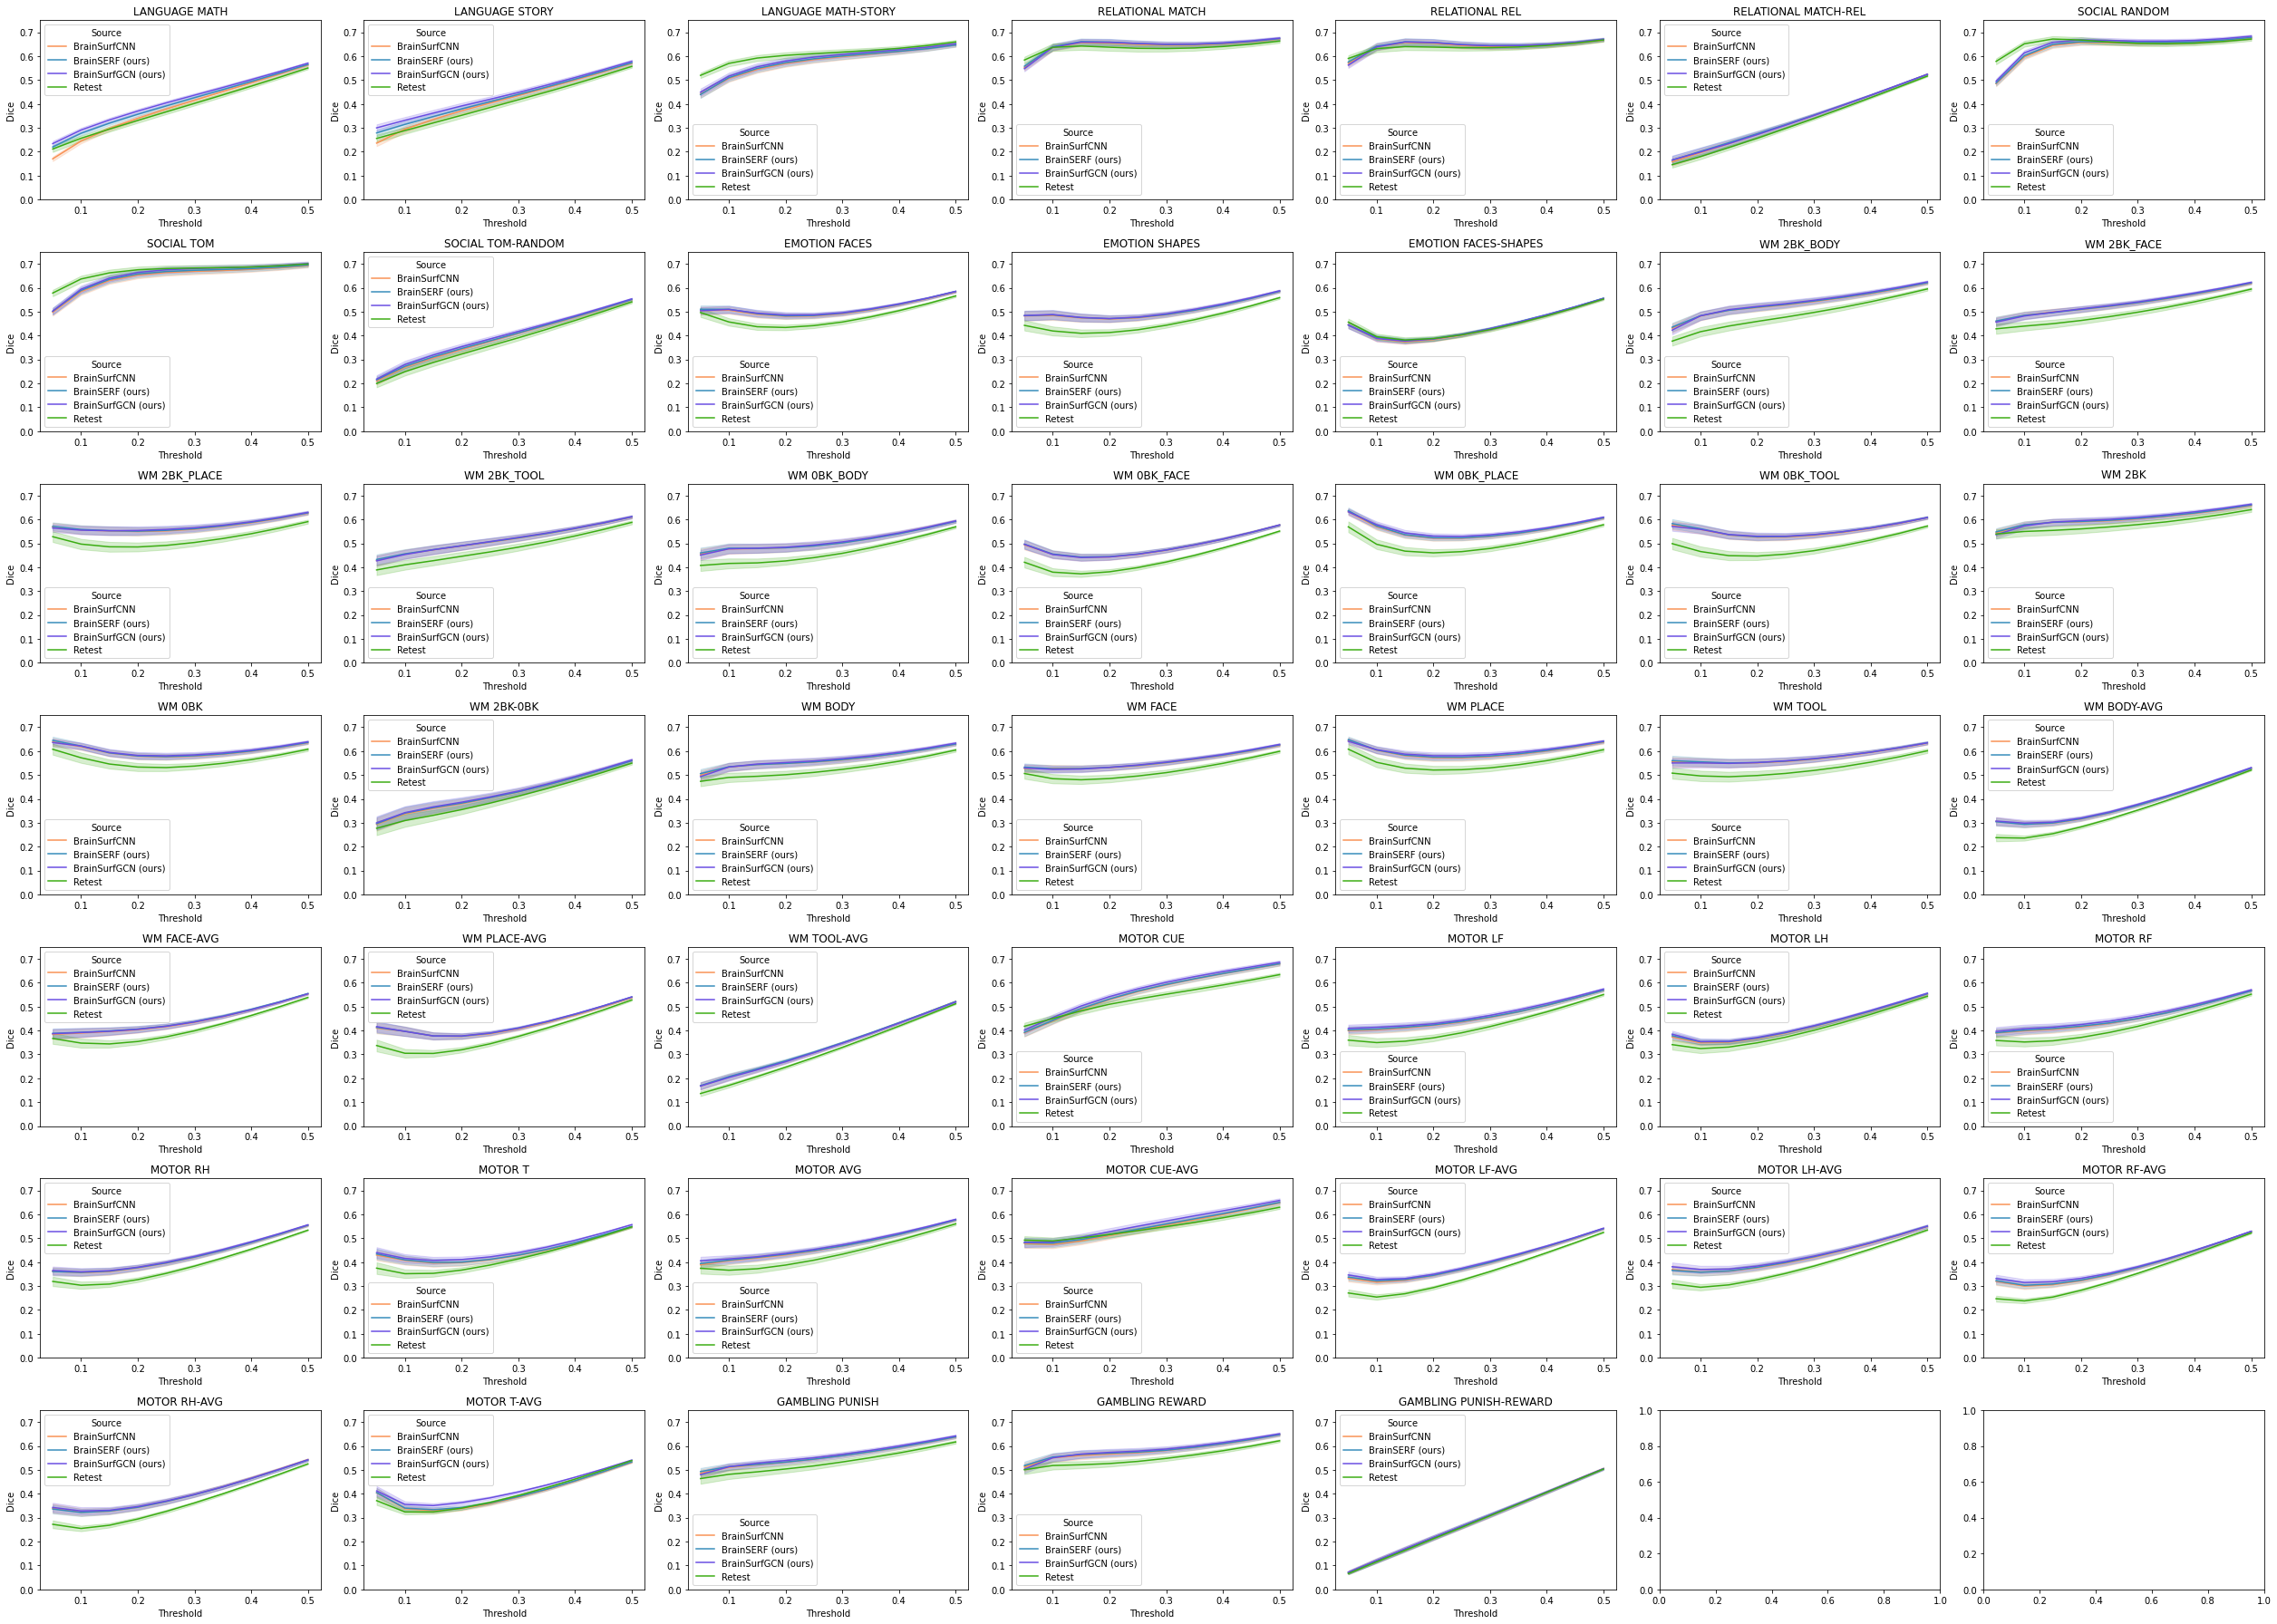

In [74]:
fig, axs = plt.subplots(7, 7, figsize=(35, 25))
for contrast_index in range(47):
    
    ax = axs[int(contrast_index / 7), contrast_index % 7]
    title = f'{CONTRASTS[contrast_index][0]} {CONTRASTS[contrast_index][-1]}'
    df = pd.DataFrame(columns=['Source', 'Subject', 'Threshold', 'Dice'])
    print(title)

    ic = 25
    brainsurf_numpy_dir = f"../../aim3_results/HCP_feat64_s8_c{ic}_lr0.01_seed28_epochs50/finetuned_feat64_s8_c{ic}_lr0.01_seed28/predict_on_test_subj/best_corr/"
    output_dir = '../../PaperPlots/retest/cortex'

    gt_dir = '../../data/test_contrasts/'
    gt_end = 'joint_LR_task_contrasts.npy'
    pred_dir = brainsurf_numpy_dir
    pred_end = 'pred.npy'

    # test_subj_ids =['917255']
    surf_scores = []
    for i in range(len(test_subj_ids)):
        subj = test_subj_ids[i]
        if pred_dir: pred_contrast = np.load(os.path.join(pred_dir, f"{subj}_{pred_end}"))
        if gt_dir: gt_contrast = np.load(os.path.join(gt_dir, f"{subj}_{gt_end}"))

        if len(pred_contrast.shape) > 2:
            pred_contrast = pred_contrast.mean(0) # average across all 8 samples used to predict

        auc, scores = dice_auc( prediction=pred_contrast,
                                groundtruth=gt_contrast,
                                mask=mask,
                                contrast_index=contrast_index,
                                dx=dx)
        for th, score in zip(threshes, scores):
            df.loc[len(df.index)] = ['BrainSurfCNN', subj, th, score]
        surf_scores.append(scores)

    surf_scores = np.array(surf_scores).T
    # print(np.mean(auc).round(3))
    # print('10%', np.round(surf_scores[1], 3))
    # print('25%', np.round(surf_scores[4], 3))
    # print('50%', np.round(surf_scores[-1], 3))
    # plot_dice_scores(threshes=threshes,
    #                  dice_scores=[surf_scores],
    #                  labels=['BrainSurfCNN'],
    #                  title=title)

    ic = 25
    brainsurf_numpy_dir = f"../../aim3_results/HCP_feat64_s8_c{ic}_lr0.01_seed28_epochs50/se_attn_finetuned_feat64_s8_c{ic}_lr0.01_seed28/predict_on_test_subj/best_corr/"
    output_dir = '../../PaperPlots/retest/cortex'

    gt_dir = '../../data/test_contrasts/'
    gt_end = 'joint_LR_task_contrasts.npy'
    pred_dir = brainsurf_numpy_dir
    pred_end = 'pred.npy'


    serf_scores = []
    for i in range(len(test_subj_ids)):
        subj = test_subj_ids[i]
        if pred_dir: pred_contrast = np.load(os.path.join(pred_dir, f"{subj}_{pred_end}"))
        if gt_dir: gt_contrast = np.load(os.path.join(gt_dir, f"{subj}_{gt_end}"))

        if len(pred_contrast.shape) > 2:
            pred_contrast = pred_contrast.mean(0) # average across all 8 samples used to predict

        auc, scores = dice_auc( prediction=pred_contrast,
                                groundtruth=gt_contrast,
                                mask=mask,
                                contrast_index=contrast_index,
                                dx=dx)
        for th, score in zip(threshes, scores):
            df.loc[len(df.index)] = ['BrainSERF (ours)', subj, th, score]
        serf_scores.append(scores)

    serf_scores = np.array(serf_scores).T
    # print(np.mean(auc).round(3))
    # print('10%', np.round(serf_scores[1], 3))
    # print('25%', np.round(serf_scores[4], 3))
    # print('50%', np.round(serf_scores[-1], 3))
    # plot_dice_scores(threshes=threshes,
    #                  dice_scores=[serf_scores],
    #                  labels=['BrainSERF'],
    #                  title=title)

    ic = 50
    brainsurf_numpy_dir = f"../../aim3_results/HCP_feat64_s8_c{ic}_lr0.01_seed28_epochs50/gnn_finetuned_feat64_s8_c{ic}_lr0.01_seed28/predict_on_test_subj/best_corr/"
    output_dir = '../../PaperPlots/retest/cortex'

    gt_dir = '../../data/test_contrasts/'
    gt_end = 'joint_LR_task_contrasts.npy'
    pred_dir = brainsurf_numpy_dir
    pred_end = 'pred.npy'


    gcn_scores = []
    for i in range(len(test_subj_ids)):
        subj = test_subj_ids[i]
        if pred_dir: pred_contrast = np.load(os.path.join(pred_dir, f"{subj}_{pred_end}"))
        if gt_dir: gt_contrast = np.load(os.path.join(gt_dir, f"{subj}_{gt_end}"))

        if len(pred_contrast.shape) > 2:
            pred_contrast = pred_contrast.mean(0) # average across all 8 samples used to predict

        auc, scores = dice_auc( prediction=pred_contrast,
                                groundtruth=gt_contrast,
                                mask=mask,
                                contrast_index=contrast_index,
                                dx=dx)
        for th, score in zip(threshes, scores):
            df.loc[len(df.index)] = ['BrainSurfGCN (ours)', subj, th, score]
        gcn_scores.append(scores)

    gcn_scores = np.array(gcn_scores).T
    # print(np.mean(auc).round(3))
    # print('10%', np.round(gcn_scores[1], 3))
    # print('25%', np.round(gcn_scores[4], 3))
    # print('50%', np.round(gcn_scores[-1], 3))

    retest_numpy_dir = '../../data/retest_contrasts/contrasts/'
    output_dir = '../../PaperPlots/retest/cortex'

    gt_dir = '../../data/test_contrasts/'
    gt_end = 'joint_LR_task_contrasts.npy'
    pred_dir = retest_numpy_dir
    pred_end = 'pred.npy'
    pred_end = 'joint_LR_task_contrasts.npy'


    retest_scores = []
    auc_scores = []
    # test_subj_ids =['917255']
    for i in range(len(test_subj_ids)):
        subj = test_subj_ids[i]
        if pred_dir: pred_contrast = np.load(os.path.join(pred_dir, f"{subj}_{pred_end}"))
        if gt_dir: gt_contrast = np.load(os.path.join(gt_dir, f"{subj}_{gt_end}"))

        if len(pred_contrast.shape) > 2:
            pred_contrast = pred_contrast.mean(0) # average across all 8 samples used to predict

        auc, scores = dice_auc( prediction=pred_contrast,
                                groundtruth=gt_contrast,
                                mask=mask,
                                contrast_index=contrast_index,
                                dx=dx)
        for th, score in zip(threshes, scores):
            df.loc[len(df.index)] = ('Retest', subj, th, score)
        retest_scores.append(scores)
        auc_scores.append(auc)


    retest_scores = np.array(retest_scores).T
    # print(retest_scores.shape)
    # print(np.mean(auc_scores).round(3))
    # print('10%', np.round(retest_scores[1], 3))
    # print('25%', np.round(retest_scores[4], 3))
    # print('50%', np.round(retest_scores[-1], 3))
    subplot_dice_scores(data=df,
                        title=title,
                        ax=ax)
    
plt.tight_layout()